## Deep Learning Analysis of TCGA Melanoma RNA-Seq Data

### Goal: Distinguish between primary and metastatic samples using:
### 1) WGCNA module eigenvalues
### 2) Cell type frequencies determined by Epic deconvolution
### 3) Epithelial and mesenchymal scores determined by ssGSEA

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics


Check GPU for tensorflow use

In [2]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print(len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

1


Set pandas option to view all columns

In [ ]:
pd.set_option('display.max_columns', None)

In [3]:
os.chdir("/Users/david/Documents/Informatics/TCGA_Melanoma_RNASeq")

Import sample metadata containing primary vs metastatic labels

In [4]:
sample_metadata = pd.read_csv("data/sample_metadata.csv", usecols = ["sample_id", "tumor_descriptor", "tissue_rollup", "ajcc_pathologic_stage"])
#sample_metadata = pd.read_csv("data/sample_metadata.csv")
sample_metadata.head()

,sample_id,tumor_descriptor,ajcc_pathologic_stage,tissue_rollup
0,mel001,Metastatic,Stage IIIC,Lymph_Nodes
1,mel002,Metastatic,Stage III,Cutanous
2,mel003,Metastatic,Stage I,Lymph_Nodes
3,mel004,Primary,Stage IIC,Cutanous
4,mel005,Metastatic,Stage IV,Cutanous


One hot encode metastatic (1) vs. primary (0)

In [6]:
def metastatic_status(row):
    if row["tumor_descriptor"] == "Metastatic":
        val = 1
    else:
        val = 0
    return val

sample_metadata["metastatic"] = sample_metadata.apply(metastatic_status, axis = 1)

sample_metadata.head()

,sample_id,tumor_descriptor,ajcc_pathologic_stage,tissue_rollup,metastatic
0,mel001,Metastatic,Stage IIIC,Lymph_Nodes,1
1,mel002,Metastatic,Stage III,Cutanous,1
2,mel003,Metastatic,Stage I,Lymph_Nodes,1
3,mel004,Primary,Stage IIC,Cutanous,0
4,mel005,Metastatic,Stage IV,Cutanous,1


Import epithelial and mesenchymal scores; only use ssGSEA scores

In [7]:
#epi_mes_score = pd.read_csv("outputs/epi_mes_signature_scores.csv", usecols=lambda x: x != "Unnamed: 0")
epi_mes_score = pd.read_csv("outputs/epi_mes_signature_scores.csv", usecols = ["Sample_ID", "ssGSEA_patient_epi_score", "ssGSEA_patient_mes_score"])
epi_mes_score.head()

,Sample_ID,ssGSEA_patient_epi_score,ssGSEA_patient_mes_score
0,mel001,0.149018,0.601737
1,mel002,0.201855,0.631269
2,mel003,0.157802,0.753784
3,mel004,0.191706,0.554946
4,mel005,0.067251,0.777031


Import WGCNA module eigenvalues

In [8]:
wgcna_module_values = pd.read_csv("outputs/WGCNA_module_eigenvalues.csv")
wgcna_module_values.rename({"Unnamed: 0" : "Sample_ID"}, axis = "columns", inplace = True)
wgcna_module_values.head()

,Sample_ID,MEblue,MEturquoise,MEyellow,MEgreen,MEmagenta,MEbrown,MEsalmon,MElightcyan,MEblack,MEgreenyellow,MEred,MEmidnightblue,MEtan,MEcyan,MEpink,MEpurple,MEgrey
0,mel354,0.020971,0.005956,-0.086223,-0.048382,-0.057826,0.023024,-0.001378,-0.012002,0.023168,-0.033896,-0.035925,0.016831,0.020362,0.051121,-0.036941,0.035503,-0.045974
1,mel432,0.044355,0.020178,0.057323,-0.032854,-0.004383,-0.024271,0.002157,-0.018926,-0.028900,-0.014615,-0.062450,-0.052693,-0.031941,-0.040906,-0.017927,-0.009794,-0.009022
2,mel243,0.028841,-0.008393,0.045201,0.043760,0.036315,-0.022660,0.002516,0.032038,0.055258,0.097136,0.003865,0.044203,0.013156,-0.049340,-0.075039,-0.015590,0.036642
3,mel321,-0.084911,-0.038733,-0.078051,0.028075,-0.022807,0.056430,0.015542,-0.004794,0.020139,-0.006115,-0.000501,-0.003662,0.027545,0.019350,0.050113,0.057358,-0.048247
4,mel218,-0.007241,0.042464,-0.071064,-0.040436,-0.052362,0.012555,-0.015324,-0.017386,-0.008267,-0.037702,0.044787,0.018398,0.018849,0.031989,0.059126,0.018955,-0.093132


Import cell type frequencies (deconvolutions)

In [9]:
deconvolutions = pd.read_csv("outputs/epic_deconvolutions.csv", skiprows = 1)
#deconvolutions.rename({"cell_type" : "Sample_ID"}, axis = "columns", inplace = True)
deconvolutions.columns = ["Sample_ID", "Bcells", "CAFs", "CD4_Tcells", "CD8_Tcells", "Endothelial", "Macrophages", "NK_cells", "Other_cells"]
deconvolutions.head()

,Sample_ID,Bcells,CAFs,CD4_Tcells,CD8_Tcells,Endothelial,Macrophages,NK_cells,Other_cells
0,mel354,1.025579e-10,0.023539,1.045116e-07,7.382235e-08,0.109605,0.005625,3.814432e-05,0.861194
1,mel432,5.479552e-02,0.022260,2.640453e-01,1.779707e-01,0.113383,0.015683,4.243849e-11,0.351862
2,mel243,6.988778e-02,0.019769,2.511736e-01,9.669438e-02,0.149864,0.011853,5.487604e-10,0.400758
3,mel321,5.082280e-09,0.026713,5.343004e-02,3.707480e-08,0.178638,0.007351,6.497756e-07,0.733868
4,mel218,1.586768e-05,0.023621,1.519758e-01,9.125375e-05,0.122105,0.010320,4.908923e-09,0.691871


Merge datasets

In [10]:
#could use reduce function
sample_data = pd.merge(epi_mes_score, wgcna_module_values, on = "Sample_ID")
sample_data = pd.merge(sample_data, deconvolutions, on = "Sample_ID")
sample_data.head()


,Sample_ID,ssGSEA_patient_epi_score,ssGSEA_patient_mes_score,MEblue,MEturquoise,MEyellow,MEgreen,MEmagenta,MEbrown,MEsalmon,MElightcyan,MEblack,MEgreenyellow,MEred,MEmidnightblue,MEtan,MEcyan,MEpink,MEpurple,MEgrey,Bcells,CAFs,CD4_Tcells,CD8_Tcells,Endothelial,Macrophages,NK_cells,Other_cells
0,mel001,0.149018,0.601737,-0.027554,0.008308,0.065262,-0.011695,0.006539,-0.007475,0.023422,0.008436,-0.020527,0.006892,-0.033263,0.050509,0.011567,0.001519,0.012380,-0.022201,-0.006652,1.006166e-01,0.022282,0.318466,0.148652,0.165866,0.016016,1.873212e-09,0.228101
1,mel002,0.201855,0.631269,-0.034268,0.011327,0.025679,0.009168,-0.003292,0.001200,0.002366,-0.018266,-0.032988,-0.015256,0.089934,0.015183,-0.023323,0.017897,0.043639,0.039837,-0.038442,4.633967e-02,0.026364,0.223059,0.121218,0.156134,0.014540,2.535559e-10,0.412345
2,mel003,0.157802,0.753784,0.036205,0.020433,0.107598,0.059451,0.042216,-0.096866,0.005888,0.005968,-0.025072,0.050142,0.001949,-0.051039,-0.094073,-0.071653,-0.048965,-0.044652,0.002794,8.955805e-02,0.026561,0.388977,0.195644,0.198778,0.015364,1.378513e-10,0.085119
3,mel004,0.191706,0.554946,-0.094093,-0.053224,-0.016999,-0.008038,-0.064231,0.086740,0.084928,0.026865,-0.023993,-0.017458,0.030773,-0.022214,-0.000901,0.016030,0.041660,0.079763,-0.083695,8.181303e-09,0.030694,0.264179,0.024643,0.135870,0.014467,1.959118e-09,0.530147
4,mel005,0.067251,0.777031,0.040886,0.017279,0.038992,0.133210,0.125685,-0.061881,-0.007971,-0.010635,-0.019254,0.025751,-0.018852,-0.071324,-0.077275,-0.180433,-0.064782,-0.115584,0.054426,8.053216e-03,0.029098,0.275838,0.084256,0.205182,0.012719,1.654998e-10,0.384855


Get shape: number of samples and features

In [11]:
sample_data.shape


(419, 28)

Check for any missing values

In [12]:
sample_data.isnull().sum()

Sample_ID                   0
ssGSEA_patient_epi_score    0
ssGSEA_patient_mes_score    0
MEblue                      0
MEturquoise                 0
MEyellow                    0
MEgreen                     0
MEmagenta                   0
MEbrown                     0
MEsalmon                    0
MElightcyan                 0
MEblack                     0
MEgreenyellow               0
MEred                       0
MEmidnightblue              0
MEtan                       0
MEcyan                      0
MEpink                      0
MEpurple                    0
MEgrey                      0
Bcells                      0
CAFs                        0
CD4_Tcells                  0
CD8_Tcells                  0
Endothelial                 0
Macrophages                 0
NK_cells                    0
Other_cells                 0
dtype: int64

Split data into training and test set

In [13]:
x_train, x_test, y_train, y_test = train_test_split(sample_data, sample_metadata, 
                                   random_state = 123,  
                                   test_size = 0.25,  
                                   shuffle = True) 


In [14]:
x_train.head()

,Sample_ID,ssGSEA_patient_epi_score,ssGSEA_patient_mes_score,MEblue,MEturquoise,MEyellow,MEgreen,MEmagenta,MEbrown,MEsalmon,MElightcyan,MEblack,MEgreenyellow,MEred,MEmidnightblue,MEtan,MEcyan,MEpink,MEpurple,MEgrey,Bcells,CAFs,CD4_Tcells,CD8_Tcells,Endothelial,Macrophages,NK_cells,Other_cells
0,mel001,0.149018,0.601737,-0.027554,0.008308,0.065262,-0.011695,0.006539,-0.007475,0.023422,0.008436,-0.020527,0.006892,-0.033263,0.050509,0.011567,0.001519,0.012380,-0.022201,-0.006652,1.006166e-01,0.022282,0.318466,0.148652,0.165866,0.016016,1.873212e-09,0.228101
236,mel265,0.164580,0.646398,-0.007147,0.000953,0.021923,0.032170,-0.012096,0.014447,0.010412,-0.000335,-0.002346,0.012826,-0.015402,-0.016718,0.010495,-0.006281,0.018071,0.034928,-0.058232,5.756868e-02,0.027959,0.243760,0.100826,0.173841,0.013207,9.120124e-10,0.382839
142,mel158,0.171015,0.645084,0.027351,0.035017,0.009240,0.022003,0.043226,-0.041420,0.001017,-0.014389,-0.019244,0.003717,-0.042560,-0.040678,-0.039198,0.081724,-0.013701,-0.120157,0.019335,1.692393e-09,0.026084,0.315195,0.035771,0.164130,0.015531,1.555791e-08,0.443289
341,mel383,0.285390,0.490575,-0.039709,-0.014794,-0.042706,-0.056609,-0.055955,0.063271,0.031900,-0.017027,0.000056,-0.026719,-0.046952,-0.024430,0.017046,0.028117,0.054653,0.059882,-0.053009,2.379470e-09,0.020322,0.162157,0.027555,0.102878,0.011614,3.095212e-09,0.675474
395,mel441,0.391954,0.518266,-0.040127,-0.064210,0.034251,-0.043457,-0.071361,0.072610,0.072112,0.029704,0.122529,0.066335,-0.052110,-0.004422,0.028948,-0.032478,0.031370,0.061320,-0.057223,1.721460e-02,0.019161,0.173689,0.175927,0.105774,0.015172,6.793008e-10,0.493062


In [15]:
x_train.shape


(314, 28)

In [16]:
y_train.shape

(314, 5)

In [17]:
x_test.head()

,Sample_ID,ssGSEA_patient_epi_score,ssGSEA_patient_mes_score,MEblue,MEturquoise,MEyellow,MEgreen,MEmagenta,MEbrown,MEsalmon,MElightcyan,MEblack,MEgreenyellow,MEred,MEmidnightblue,MEtan,MEcyan,MEpink,MEpurple,MEgrey,Bcells,CAFs,CD4_Tcells,CD8_Tcells,Endothelial,Macrophages,NK_cells,Other_cells
11,mel013,0.330344,0.565402,-0.007634,0.033754,-0.018994,-0.026662,-0.015580,-0.015461,-0.005218,-0.004197,0.069747,0.030789,-0.036769,-0.034747,-0.033372,-0.008595,0.013374,0.027366,-0.029941,4.600864e-10,0.019737,0.250741,3.013406e-07,0.129555,0.014518,2.724409e-05,0.585421
24,mel027,0.288616,0.612249,-0.087314,0.001992,0.033883,0.022042,-0.022838,0.015602,-0.000278,0.225600,0.045754,0.031893,0.080397,0.089682,0.044820,-0.059646,0.044534,0.044857,-0.052411,6.748901e-02,0.027110,0.229437,1.209685e-01,0.134396,0.013154,6.618052e-08,0.407446
36,mel040,0.196585,0.490855,0.035476,0.021721,-0.064626,-0.072675,-0.041236,0.001885,-0.066529,0.009002,-0.024642,-0.075608,0.029021,0.033126,0.042922,-0.016094,0.024709,0.029008,-0.018370,6.594533e-07,0.019088,0.106623,2.545346e-02,0.127699,0.007771,2.916608e-09,0.713365
291,mel326,0.167399,0.601622,-0.003984,0.039347,0.018409,-0.028231,-0.032717,-0.008551,-0.001186,-0.017588,-0.031455,-0.019307,-0.043792,-0.109984,-0.067276,0.078259,0.055563,0.052036,-0.081607,6.506857e-02,0.021529,0.242292,8.078320e-02,0.116407,0.012982,1.228716e-09,0.460939
15,mel018,0.221638,0.512973,0.081921,-0.005906,-0.020872,0.001026,-0.023712,-0.012104,-0.043334,0.009306,-0.002607,0.007138,-0.001344,0.069763,0.079297,-0.135761,-0.090518,0.015527,0.027966,2.788258e-08,0.019066,0.157192,5.062320e-02,0.141009,0.012138,3.703675e-09,0.619971


In [18]:
x_test.shape

(105, 28)

Define neural network layers

In [19]:
# define the keras model
model = Sequential()
model.add(Dense(16, input_shape=(27,), activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
#model.add(Dense(2, activation='softmax'))

2024-02-28 10:19:58.641983: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-02-28 10:19:58.642020: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 128.00 GB
2024-02-28 10:19:58.642031: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 48.00 GB
2024-02-28 10:19:58.642101: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-28 10:19:58.642146: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                448       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 737 (2.88 KB)
Trainable params: 737 (2.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Define model loss, optimizer and metric functions

In [54]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=[keras.metrics.AUC()])
#model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['sparse_categorical_accuracy'])
#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Fit model to training data; include validation split

In [72]:
# fit the keras model on the dataset
model.fit(x_train.iloc[:,1:28], 
          y_train["metastatic"], 
          validation_split = 0.2,
          epochs = 100, 
          batch_size = 35, 
          verbose = 2)

Epoch 1/100
8/8 - 1s - loss: 0.3208 - auc: 0.9024 - val_loss: 0.1865 - val_auc: 0.9923 - 862ms/epoch - 108ms/step
Epoch 2/100
8/8 - 0s - loss: 0.3196 - auc: 0.9041 - val_loss: 0.1822 - val_auc: 0.9923 - 99ms/epoch - 12ms/step
Epoch 3/100
8/8 - 0s - loss: 0.3214 - auc: 0.9018 - val_loss: 0.1882 - val_auc: 0.9923 - 101ms/epoch - 13ms/step
Epoch 4/100
8/8 - 0s - loss: 0.3210 - auc: 0.9011 - val_loss: 0.1998 - val_auc: 0.9923 - 99ms/epoch - 12ms/step
Epoch 5/100
8/8 - 0s - loss: 0.3194 - auc: 0.9038 - val_loss: 0.1860 - val_auc: 0.9923 - 86ms/epoch - 11ms/step
Epoch 6/100
8/8 - 0s - loss: 0.3206 - auc: 0.9032 - val_loss: 0.1962 - val_auc: 0.9923 - 81ms/epoch - 10ms/step
Epoch 7/100
8/8 - 0s - loss: 0.3204 - auc: 0.9023 - val_loss: 0.2135 - val_auc: 0.9923 - 81ms/epoch - 10ms/step
Epoch 8/100
8/8 - 0s - loss: 0.3203 - auc: 0.9037 - val_loss: 0.1912 - val_auc: 0.9923 - 82ms/epoch - 10ms/step
Epoch 9/100
8/8 - 0s - loss: 0.3200 - auc: 0.9024 - val_loss: 0.1972 - val_auc: 0.9923 - 83ms/epoch -

Generate predictions on test data

In [73]:
#predict on test data
predictions = model.predict(x_test.iloc[:,1:28])
print(predictions)

4/4 [==============================] - 0s 3ms/step
[[0.11330648]
 [0.9308856 ]
 [0.7430317 ]
 [0.86713207]
 [0.39949968]
 [0.779246  ]
 [0.96116316]
 [0.99502605]
 [0.9872335 ]
 [0.68095386]
 [0.72735786]
 [0.0882221 ]
 [0.06953003]
 [0.589882  ]
 [0.817715  ]
 [0.953097  ]
 [0.9649402 ]
 [0.44274893]
 [0.3606133 ]
 [0.9942484 ]
 [0.9782804 ]
 [0.79539996]
 [0.46146557]
 [0.9828047 ]
 [0.948219  ]
 [0.6660182 ]
 [0.04169055]
 [0.9938823 ]
 [0.92838866]
 [0.89864314]
 [0.00593755]
 [0.61111045]
 [0.8641182 ]
 [0.68685305]
 [0.89837617]
 [0.82912725]
 [0.785805  ]
 [0.9861107 ]
 [0.0381355 ]
 [0.98872   ]
 [0.7029358 ]
 [0.94927573]
 [0.8952393 ]
 [0.21667343]
 [0.9467648 ]
 [0.9629065 ]
 [0.5116418 ]
 [0.04483099]
 [0.18537709]
 [0.83767986]
 [0.7222796 ]
 [0.8257858 ]
 [0.97653687]
 [0.02085808]
 [0.98640996]
 [0.96339005]
 [0.85611147]
 [0.35937083]
 [0.80545527]
 [0.9857679 ]
 [0.77260685]
 [0.28304166]
 [0.9028544 ]
 [0.89742744]
 [0.8178627 ]
 [0.8456248 ]
 [0.9806276 ]
 [0.5728078

Make model predictions into a dataframe

In [74]:
predictions = pd.DataFrame(predictions,
                           columns = ["Model_Value"])
predictions.head()

,Model_Value
0,0.113306
1,0.930886
2,0.743032
3,0.867132
4,0.399500


Round predictions into 0 (primary) and 1 (metastatic) values

In [75]:
predictions["Prediction"] = predictions.iloc[:,0].round(0)
predictions.head()

,Model_Value,Prediction
0,0.113306,0.0
1,0.930886,1.0
2,0.743032,1.0
3,0.867132,1.0
4,0.399500,0.0


Generate a confusion matrix

In [76]:
conf_maxtrix = confusion_matrix(y_true = y_test["metastatic"],
                                y_pred = predictions["Prediction"])
print(conf_maxtrix)

[[12 15]
 [12 66]]


Plot confusion matrix

[Text(0, 0.5, 'Primary'), Text(0, 1.5, 'Metastatic')]

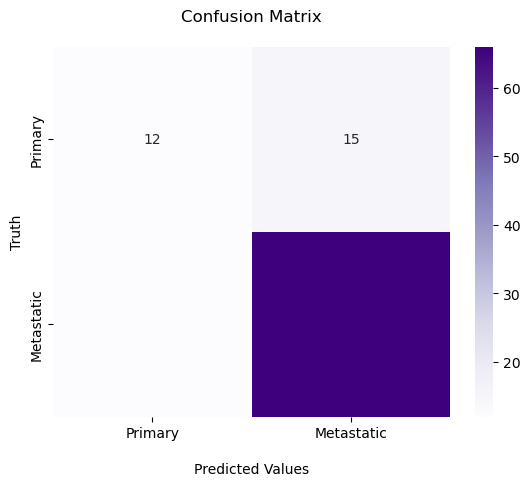

In [69]:
ax = sns.heatmap(conf_maxtrix, annot = True, cmap = 'Purples')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Truth');

ax.xaxis.set_ticklabels(['Primary','Metastatic'])
ax.yaxis.set_ticklabels(['Primary','Metastatic'])

#bottom annotations are missing?


Plot confusion matrix a different way

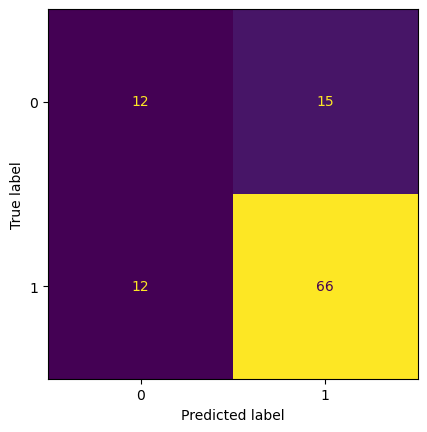

In [70]:
ConfusionMatrixDisplay.from_predictions(y_test["metastatic"], 
                                        predictions["Prediction"],
                                        colorbar = False)

Make a function for generating a line with slop 1 to use in the ROC plot

In [62]:
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

ROC AUC plot

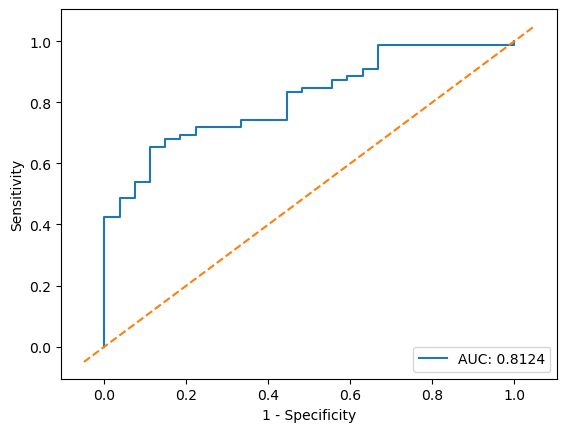

In [77]:
fpr, tpr, _ = metrics.roc_curve(y_test["metastatic"], 
                                predictions.iloc[:,0])

auc = metrics.roc_auc_score(y_test["metastatic"], 
                                predictions.iloc[:,0])

plt.plot(fpr, tpr, label = "AUC: "+str(auc.round(4)))
abline(1,0)
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.legend(loc = 4)
plt.show()